In [1]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import os, imageio
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import TensorDataset
from torch import nn, optim
from itertools import chain
import matplotlib.pyplot as plt
import random

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f"Using {device} device")

Using cuda device


In [9]:
# Make dataset, taken from https://github.com/jmclong/random-fourier-features-pytorch
image = torchvision.io.read_image('cat.jpg').float()
_, H, W = image.shape
def linspace_func(nx): return torch.linspace(0.0, 1.0, nx)
linspaces = map(linspace_func, (H, W))
coordinates = torch.meshgrid(*linspaces, indexing='ij')
coords = torch.stack(coordinates, dim=-1)
image = image.permute((1, 2, 0))
image /= 255.0
coords = coords.flatten(0, -2)
image = image.flatten(0, -2)
dataset = TensorDataset(coords, image)

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices = indices

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)

train_dataloader = DataLoader(dataset, batch_size=256, sampler=train_sampler)
expand_dataloader = DataLoader(dataset, batch_size=1024, sampler=train_sampler)

In [5]:
# Fourier transform receive layer
class TransitionLayer(nn.Module):
    def __init__(self, size):
        super(TransitionLayer, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(nn.Linear(size,64))

    def forward(self, x):
        return self.layers(x)
    
# Fourier Space MLP fit
class NeuralNetwork(nn.Module):
    def  __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            #nn.Linear(10, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.layers(x)

# Gaussian Encoding Layer
class GaussianEncoding(nn.Module):
  def __init__(self, sigma, input_size, feature_num):
    super(GaussianEncoding, self).__init__()
    self.b = torch.randn((feature_num, input_size)) * sigma
    self.b = self.b.to(device)

  def forward(self, x):
    return torch.sin(2 * np.pi * x @ self.b.T)

In [131]:
# Samples many rffs and incorporates the one with the best dLoss wrt to weights
def expandModel(feature_num, model, transition_layer, encoding, dummies):
    b, (X, y) = next(enumerate(expand_dataloader))
    X = X.to(device)
    y = y.to(device)
    # Pad the transition layer
    transition_sd = transition_layer.state_dict()
    expanded_transition = TransitionLayer(feature_num).to(device)
    expanded_transition.load_state_dict(transition_sd)
    trans_weights = transition_layer.layers[0].weight
    pad_weights = torch.nn.Parameter(F.pad(input=trans_weights, pad=(0,1,0,0), mode='constant', value=0))
    expanded_transition.layers[0].weight = pad_weights

    initDummyLayers(encoding, dummies)
    z = transition_layer(encoding(X))
    preds = model(z)
    gz = sum(preds)
    #print(z.shape)
    #print(gz.shape)
    dgdz = torch.zeros([3,z.shape[0],z.shape[1]])
    for i in range(3):
      dgdz_coord = torch.autograd.grad(gz[i], z, retain_graph=True)
      dgdz[i,:,:] = dgdz_coord[0]
    #print('dgdz')
    #print(dgdz.shape)
    dgdz = dgdz.to(device)
    best_dldw = 0
    for dummy in dummies:
      a = dummy.b[-1]
      ax = torch.matmul(a, torch.permute(X, (1,0)))
      pred_minus_y = torch.add(preds,y,alpha=-1)
      pred_minus_y = torch.reshape(pred_minus_y,(pred_minus_y.shape[0],pred_minus_y.shape[1],1))
      pred_minus_y = torch.permute(pred_minus_y, (1,0,2))
      #print('p - y')
      #print(pred_minus_y.shape)
      two_terms = torch.mul(pred_minus_y, dgdz)
      #print('ax')
      #print(ax.shape)
      #print (two_terms.shape)
      dLdw = torch.mul(torch.permute(two_terms,(0,2,1)), torch.sin(ax))
      #print('dLdw')
      #print(dLdw.shape)
      dLdw = torch.sum(dLdw, dim=(0,2))
      #print('dLdw summed over dimensions')
      #print(dLdw)
      norm = torch.linalg.vector_norm(dLdw)
      #print('norm')
      #print(norm)
      if norm > best_dldw:
        best_dldw = norm
        best_dummy = dummy
    print('new feature with dldw: ' + str(best_dldw))
    return best_dummy, expanded_transition

def initDummyLayers(encoding, dummies):
  b_padded = torch.nn.Parameter(F.pad(input=encoding.b, pad=(0,0,0,1), mode='constant', value=0))
  sd = encoding.state_dict()
  for dummy in dummies:
    dummy.load_state_dict(sd, strict=False)
    dummy.b = b_padded
    dummy.b.data[-1] = torch.randn((1,2))

def checkStall(losses):
    n = 300
    iter = len(losses) - 1
    if iter < n: return False
    time = np.array([i for i in range(n)])
    loss_array = np.array(losses[-(n+1):-1])
    p = np.polyfit(time, loss_array, 1)
    return p[0] > 0

In [132]:
#Training code
feature_num = 2
transition_layer = TransitionLayer(feature_num)
transition_layer = transition_layer.to(device)
model = NeuralNetwork()
model = model.to(device)

loss_fn = nn.MSELoss()
params = chain(transition_layer.parameters(), model.parameters())
optimizer = optim.Adam(params, lr=1e-4) 
encoding = GaussianEncoding(1., 2, feature_num).to(device)
epochs = 5

losses = []
stalls = []
batch_losses = []

for epoch in range(epochs):
  for batch_index, (X, y) in enumerate(train_dataloader):
    X = X.to(device)
    y = y.to(device)
    Xp = encoding(X)
    pred = model(transition_layer(Xp))
    loss = loss_fn(pred, y)
    losses.append(loss.item())
    if (len(losses) + 1) % 1000 == 0:
      print("loss: " + str(np.mean(losses[-1:-101:-1])))
    #if False:
    if((len(losses) + 1) % 100 == 0 and checkStall(losses)):
      stalls.append(len(losses))
      dummies = [GaussianEncoding(1., 2, feature_num).to(device) for i in range(100)]
      encoding, transition_layer = expandModel(feature_num, model, transition_layer, encoding, dummies)
      params = chain(transition_layer.parameters(), model.parameters())
      optimizer = optim.Adam(params, lr=1e-4)
      feature_num += 1
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
with torch.no_grad():
    coords = rff.dataloader.rectangular_coordinates((512, 512)).to(device)
    coords = encoding(coords)
    image = model(transition_layer(coords))
    plt.imshow(image.cpu().numpy())
    plt.show()

new feature with dldw: tensor(1.8129, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
loss: 0.044721625931560996
new feature with dldw: tensor(1.5020, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
new feature with dldw: tensor(6.5563, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
loss: 0.0353593491576612
loss: 0.027405816819518803
loss: 0.02118826949968934
loss: 0.017031769370660185
new feature with dldw: tensor(3.9199, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
loss: 0.014531509755179285
new feature with dldw: tensor(3.2978, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
loss: 0.01089406040031463
loss: 0.008677089065313339
new feature with dldw: tensor(12.0910, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
loss: 0.0068910382455214855
loss: 0.005731681257020682


KeyboardInterrupt: ignored

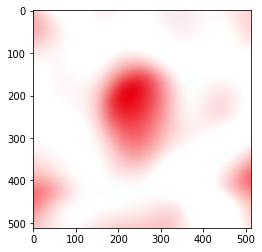

In [128]:
#Visualize model
with torch.no_grad():
    coords = rff.dataloader.rectangular_coordinates((512, 512)).to(device)
    image = model(transition_layer(encoding(coords)))
    plt.imshow(image.cpu().numpy())
    plt.show()

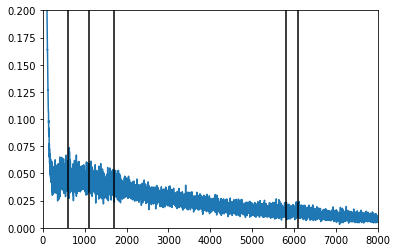

In [141]:
#Visualize loss over iteration and stalls
plt.plot(losses)
for stall in stalls:
  plt.axvline(x=stall, color = 'k')
plt.axis([0,8000,0,0.2])
plt.show()